In [1]:
import os
os.chdir("../../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product
from src.tourism.ts_utils import check_and_modify_date
from src.tourism.mtsmodel import *
from src.tourism.utsmodel import *
from src.tourism.data import *

In [2]:
mod_s = SARIMAXPipeline("samoa",
                        y_var="total",
                        exog_var=["covid", "stringency_index"],
                        transform_method="scaledlogit",
                        training_ratio=0.9)
mod_s.read_and_merge()
mod_s.transform()
mod_s.stepwise_search()
mod_s.manual_search()

training size : 217, testing size : 25
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=656.822, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=671.301, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=600.330, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=669.303, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=631.706, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=561.661, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=611.642, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=554.270, Time=0.59 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=555.343, Time=0.91 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=555.804, Time=0.63 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=608.506, Time=0.45 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=532.392, Time=0.92 sec
 A

100%|█████████████████████████████████████████| 324/324 [05:37<00:00,  1.04s/it]


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14dc07cd0>,
  456.4964238035768,
  ((0, 1, 1), (2, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14dbadf70>,
  457.22515754423597,
  ((0, 1, 1), (1, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14db8d940>,
  457.42122363499254,
  ((0, 1, 1), (1, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x168b7ea90>,
  457.52291375991155,
  ((1, 0, 1), (2, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x168acee80>,
  458.1164718549237,
  ((1, 0, 1), (1, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2995c9640>,
  458.332266298108,
  ((2, 0, 2), (2, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1772e5d00>,
  458.34861521493366,
  ((1, 1, 1), (2, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14dddc4f0>,
  458.35142144922

In [2]:
mod = RatioPipe("samoa",
                y_var="total",
                exog_var=["covid", "stringency_index"],
                transform_method="scaledlogit",
                training_ratio=0.9)
mod.read_and_merge()
mod.transform()
mod.fit("ratio ~ covid*stringency_index + C(quarter) + samoa_travel")

In [3]:
X_future = mod.covid_raw.merge(mod.trends_raw, how="right")[["date", "samoa travel", "covid", "stringency_index"]]
X_future["quarter"] = X_future["date"].dt.quarter
X_future.columns = [col.replace(" ", "_") for col in X_future.columns]

In [4]:
X_future = X_future[X_future.date >= "2019-01-01"].fillna(0).reset_index(drop=True)

In [5]:
mod_prediction = mod.res.get_prediction(X_future).summary_frame()
for idx in mod.model_data.index:
    mod_prediction.iloc[idx, :] = mod_prediction.iloc[idx, :] * mod.model_data["seats_arrivals_intl"][idx]
    
mod_prediction["date"] = X_future["date"]
mod_prediction = mod_prediction[mod_prediction.date < "2023-11-01"]

In [25]:
from src.tourism.ts_eval import *

calculate_evaluation(real_df["actual_visitor"], real_df["predict"])

{'MSE': 27076663.401289623,
 'RMSE': 5203.524132863191,
 'MAE': 4353.219048163771,
 'SMAPE': 50.09592507891855}

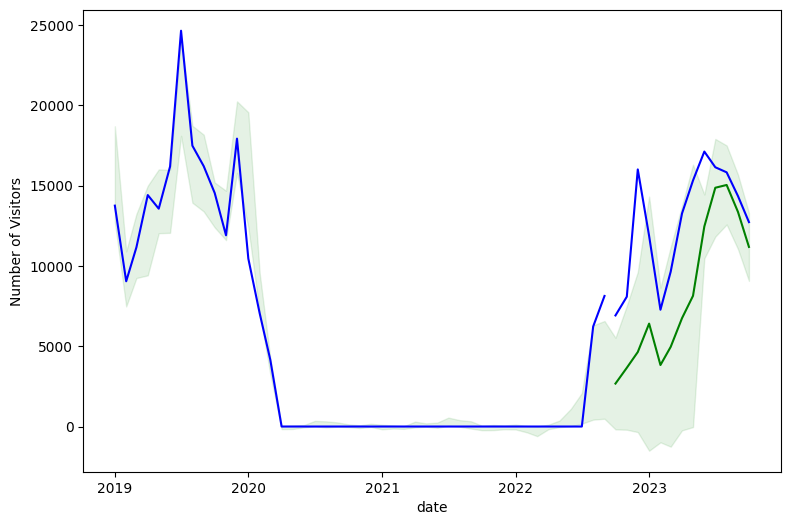

In [27]:
real = [
    6917, 8085, 16009, 11868, 7273, 9643, 13271, 15321, 17122, 16145, 15829,
    14351, 12729
]

real_df = pd.DataFrame({
    "date":
    pd.date_range(start="2022-10-01", periods=len(real), freq="MS"),
    "actual_visitor":
    real
})
real_df["predict"] = mod_prediction["mean"][45:].tolist()

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(data=real_df, x="date", y="actual_visitor", ax=ax, color="blue")
sns.lineplot(data=mod.model_data, x="date", y="total", ax=ax, color="blue")
sns.lineplot(data=real_df, x="date", y="predict", ax=ax, color="green")
plt.fill_between(x=mod_prediction.date,
                 y1=mod_prediction.mean_ci_lower,
                 y2=mod_prediction.mean_ci_upper,
                 alpha=0.1,
                 color="green")
ax.set_ylabel("Number of Visitors")
plt.show()